# `pandas dtypes` 

In [Section 1.1](./1_1_introduction_to_pandas.ipynb), we took our first look at the `pandas.DataFrame`.  In this section, we will take a closer look at `pandas` column types.

In [1]:
import pandas as pd
from dfply import *

## Hiding stack traceback

We hide the exception traceback for didactic reasons (code source: [see this post](https://stackoverflow.com/questions/46222753/how-do-i-suppress-tracebacks-in-jupyter)).  Don't run this cell if you want to see a full traceback.

In [3]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

## Outline

* Three more `dtypes`
    * `datetime`
    * `Int64`
    * `category`
* Setting the `dtypes` at read time.

## Integers with missing values

* Older `pandas` $\rightarrow$ no missing `int`
    * Use `float` instead
* Latest version $\rightarrow$ `Int` classes
    * Notice the capital `I`

## Example - Artist `BeginDate` and `EndDate`

In [4]:
artist = pd.read_csv('./data/Artists.csv')
artist.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN


## There are lots of `0`s in the `BeginDate` 

Do we really think the Museam of **Modern** Art has artists from 0AD?

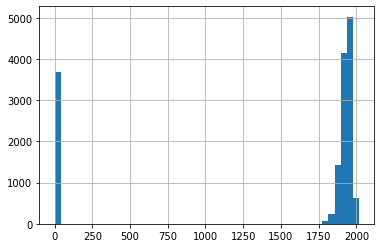

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
artist.BeginDate.hist(bins=50)

## Same problem with `EndDate`, but even more so

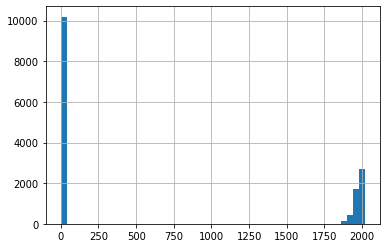

In [6]:
artist.EndDate.hist(bins=50)

## Using `apply` to remove the `0`s

In [7]:
transformed_BD = artist.BeginDate.apply(lambda val: np.nan if val == 0 else val)
transformed_BD.head()

0    1930.0
1    1936.0
2    1941.0
3    1946.0
4    1941.0
Name: BeginDate, dtype: float64

## What's up with the `float dtype`?

Good question, let's find out.

## Converting transformed `BeginDate` - attempt 1

Let's try to convert the `BeginDate` to `int`

In [9]:
transformed_BD.astype('int')

ValueError: Cannot convert non-finite values (NA or inf) to integer

## `pandas`, `int` and `np.nan` don't mix

* `pandas` `int` columns **cannot** have missing
* `pd.__version__ == 0.24.1` fixes this
    * Use `Int64` for integers with missing values
    * Note the capital `I`
* Update with `!pip install --upgrade pandas`

In [11]:
# TODO Make this future proof
assert pd.__version__.startswith('0.24'), "Please upgrade your pandas and restart jupyter"
#!pip install --upgrade pandas

AssertionError: Please upgrade your pandas and restart jupyter

## Converting `BeginDate` to `Int64`

Hmm, that returned a `float` column.  Let's try to force `Int64`

In [8]:
transformed_BD.astype('Int64').head(15) # There we go!

0     1930
1     1936
2     1941
3     1946
4     1941
5     1925
6     1941
7     1923
8     1918
9     1886
10    1936
11    1911
12    1907
13    1900
14    <NA>
Name: BeginDate, dtype: Int64

## Example 2 - Uber rides

**Source:** [FiveThirtyEight Uber data](https://github.com/fivethirtyeight/uber-tlc-foil-response)

**Note:** The actual data is pretty large, which we will deal with in the next section.  For now, we will load a subset (first 1000 rows).

In [9]:
uber_april_raw = pd.read_csv("https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/master/uber-trip-data/uber-raw-data-apr14.csv")
uber_april_raw.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


## <font color="red"> Exercise 1</font>

Fix the names.  Be sure to rename the `"Date/Time"` `'date'` and name the resulting data frame `uber_april_renamed`.

In [10]:
uber_april_renamed = uber_april_raw.rename(columns = {'Date/Time':'Date'})
uber_april_renamed.head()

,Date,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


## <font color="red"> Exercise 2</font>

**Tasks:**

1. Inspect the `dtypes`
2. Suggest a good type for the `date` column

In [11]:
uber_april_renamed.dtypes

Date     object
Lat     float64
Lon     float64
Base     object
dtype: object

The Date column should be datetime64 since it contains dates and time when it was recorded. 

## Changing to date type with  `pd.to_datetime`

In [12]:
pd.to_datetime(uber_april_renamed.Date.head())

0   2014-04-01 00:11:00
1   2014-04-01 00:17:00
2   2014-04-01 00:21:00
3   2014-04-01 00:28:00
4   2014-04-01 00:33:00
Name: Date, dtype: datetime64[ns]

## Making a `dfply` compatible column function.

Suppose you have a function you want to use inside `mutate` (i.e. a **column function**).  To make this function compatable with `dfply.Intention`s, you should 

1. Wrap the `pandas` call inside a function.
2. Decorate with `@make_symbolic`

In [13]:
@make_symbolic
def to_datetime(series, infer_datetime_format=True):
    return pd.to_datetime(series, infer_datetime_format=infer_datetime_format)

## Converting to dates with `dfply`

Note that above function is available in `more_dfply.to_datetime` is a `dfply` compatible version of `pd.to_datetime`.

In [74]:
#pip install unpythonic

     |████████████████████████████████| 238 kB 5.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
from more_dfply import to_datetime
uber_april = (uber_april_renamed >>
                mutate(Date = to_datetime(X.Date)))
uber_april.dtypes

Date    datetime64[ns]
Lat            float64
Lon            float64
Base            object
dtype: object

In [27]:
uber_april.head()

,Date,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


## Why convert to `datetime`?

This series type provides many useful date methods and attributes.  For example, we get many **dateparts methods** in the `dt` attribute.

In [41]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages (1.2.1)


In [47]:

uber_april_weekday = (uber_april  >>
                        mutate(weekday = X['Date'].dt.day_name()))
uber_april_weekday.head()

,Date,Lat,Lon,Base,weekday
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday


## <font color="red"> Exercise 3</font>

**Tasks:**

1. Use `dir` to inspect the dateparts found in `dt`
2. Add a few more datepart columns.
3. Name the resulting dataframe `uber_april_datepart`

In [61]:
dir(pd.Series.dt)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_add_delegate_accessors',
 '_constructor',
 '_delegate_method',
 '_delegate_property_get',
 '_delegate_property_set',
 '_dir_additions',
 '_dir_deletions',
 '_freeze',
 '_get_values',
 '_hidden_attrs',
 '_reset_cache',
 'asfreq',
 'ceil',
 'components',
 'date',
 'day',
 'day_name',
 'day_of_week',
 'day_of_year',
 'dayofweek',
 'dayofyear',
 'days',
 'days_in_month',
 'daysinmonth',
 'end_time',
 'floor',
 'freq',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'isocalendar',
 'microsecond',
 'micr

In [73]:
uber_april_datepart = (uber_april 
                       >>
                        mutate(weekday = X['Date'].dt.day_name())
                       >>
                        mutate(month = X['Date'].dt.month)
                       >> 
                       mutate(time = X['Date'].dt.time)
                       >>
                       mutate(year = X['Date'].dt.year))

uber_april_datepart.head()

,Date,Lat,Lon,Base,weekday,month,time,year
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,4,00:11:00,2014
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,4,00:17:00,2014
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,4,00:21:00,2014
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,4,00:28:00,2014
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,4,00:33:00,2014


## Specifying date columns while reading

Pass a list of date columns to `parse_dates`

In [75]:
from toolz import first
uber_april_with_datetime = pd.read_csv("https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/master/uber-trip-data/uber-raw-data-apr14.csv", 
                                       parse_dates=['Date/Time'])

uber_april_with_datetime.dtypes

Date/Time    datetime64[ns]
Lat                 float64
Lon                 float64
Base                 object
dtype: object

## Explicit date parsing

* Create a parser function
* Pass to `date_parser`
* Use if `pandas` fails to parse
* More information about format codes [here](https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior)

In [ ]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
uber_april_parsered = pd.read_csv('https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/master/uber-trip-data/uber-raw-data-apr14.csv', 
                              parse_dates=['Date/Time'],
                              date_parser=dateparse)
uber_april_parsered.head()

/home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/io/parsers.py:3334: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/io/parsers.py", line 3318, in converter
    date_parser(*date_cols), errors="ignore", cache=cache_dates
  File "<ipython-input-76-00bae23dfb74>", line 1, in <lambda>
    dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
TypeError: strptime() argument 1 must be str, not numpy.ndarray

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/io/parsers.py", line 3329, in converter
    dayfirst=dayfirst,
  File "pandas/_libs/tslibs/parsing.pyx", line 589, in pandas._libs.tslibs.parsing.try_parse_dates
  File "<ipython-input-76-00bae23dfb74>", line 1, in <lambda>
    dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
  File "/home/vn6415dw/.pyenv/versions/anaconda3-2020.02/lib/python3.7/_strptime

## Categorical dtype

* Similar to `R`s factor
* Allows for nominal or ordinal categories

In [76]:
uber_april_weekday_cat = (uber_april_weekday >>
                            mutate(weekday = X.weekday.astype('category')))
uber_april_weekday_cat.dtypes

ERROR! Session/line number was not unique in database. History logging moved to new session 319


Date       datetime64[ns]
Lat               float64
Lon               float64
Base               object
weekday          category
dtype: object

## Let's plot the weekdays with `seaborn.catplot`

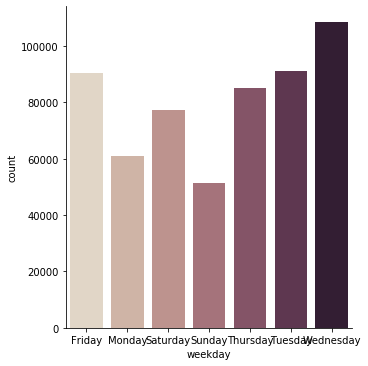

In [77]:
import seaborn as sns
sns.catplot(x="weekday", 
            kind="count", 
            palette="ch:.25", 
            data=uber_april_weekday_cat);

## Nominal by default

* Setting `'category'` makes this nominal
* Weekdays are actually ordinal
* Notice the alphabetical order in the plot.

## Making the data ordinal

1. Make a new category class with `CategoricalDtype`
2. Use `astype` with your new dtype class

#### Making an order weekday category

In [79]:
from calendar import day_name
list(day_name)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [81]:
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)
weekday_categories

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
, ordered=True)

#### Changing to our custom type

In [82]:
uber_april_weekday_ord = (uber_april_weekday >>
                            mutate(weekday = X.weekday.astype(weekday_categories)))
uber_april_weekday_ord.dtypes

Date       datetime64[ns]
Lat               float64
Lon               float64
Base               object
weekday          category
dtype: object

## Plot the ordinal weekdays with `seaborn.catplot`

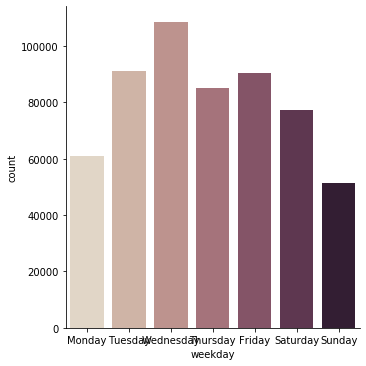

In [83]:
import seaborn as sns
sns.catplot(x="weekday", 
            kind="count", 
            palette="ch:.25", 
            data=uber_april_weekday_ord);

## <font color="red"> Exercise 4</font>

Sometimes there is an advantage to treating calendar years as ordinal data.  Perform the following steps on the `Artist` data loaded above.

**Tasks:**

1. Remove the `0` from `BeginDate` and switch the type to `Int64`.
2. Filter out the rows that are missing `BeginDate`
3. Determine the minimum and maximum values of the filtered `BeginDate`s
4. Create a new ordinal category class for this date range.
5. Use `sns.catplot` to plot the distribution of the dates.

In [86]:
artist.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN


In [91]:
artist['BeginDate_Nan'] = artist['BeginDate'].replace(0,np.nan)
artist.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,BeginDate_Nan
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN,1930.0
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN,1936.0
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN,1941.0
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0,1946.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN,1941.0


In [104]:
artist['BeginDate_Nan'] =artist['BeginDate_Nan'].astype('Int64')

In [105]:
artist.dtypes

ConstituentID      int64
DisplayName       object
ArtistBio         object
Nationality       object
Gender            object
BeginDate          int64
EndDate            int64
Wiki QID          object
ULAN             float64
BeginDate_Nan      Int64
dtype: object

In [111]:
artist_filtered = (artist >>
filter_by(X['BeginDate_Nan'].notnull()))
artist_filtered.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,BeginDate_Nan
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN,1930
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN,1936
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN,1941
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0,1946
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN,1941


In [165]:
min(artist_filtered['BeginDate_Nan'])

1181

In [166]:
max(artist_filtered['BeginDate_Nan'])

2017

In [201]:
artist_filtered['years_bins'] = pd.cut(x=artist_filtered['BeginDate_Nan'], bins=[1100,1650, 1900,1930,1960,2000, 2017])
artist_filtered.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,BeginDate_Nan,BeginDate_Cat,years_bins
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN,1930,1930,"(1900, 1930]"
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN,1936,1936,"(1930, 1960]"
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN,1941,1941,"(1930, 1960]"
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0,1946,1946,"(1930, 1960]"
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN,1941,1941,"(1930, 1960]"


In [141]:
artist_filtered['BeginDate_Cat'] = artist_filtered['BeginDate_Nan'].astype('category')
artist_filtered.dtypes


ConstituentID       int64
DisplayName        object
ArtistBio          object
Nationality        object
Gender             object
BeginDate           int64
EndDate             int64
Wiki QID           object
ULAN              float64
BeginDate_Nan       Int64
BeginDate_Cat    category
years_bins       category
dtype: object

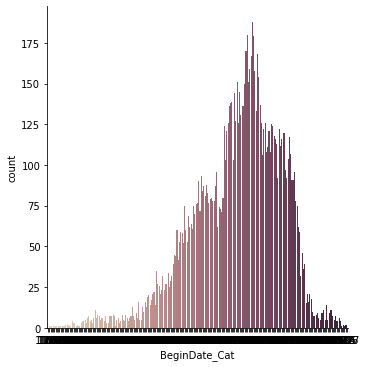

In [136]:
import seaborn as sns
sns.catplot(x=artist_filtered["BeginDate_Cat"], 
            kind="count", 
            palette="ch:.25", 
            data=artist_filtered);

In [207]:
import matplotlib.pyplot as plt

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

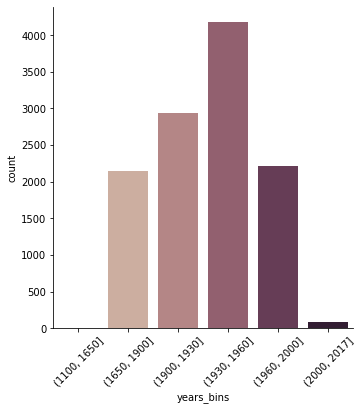

In [230]:
ax = sns.catplot(x='years_bins', 
            kind="count", 
            palette="ch:.25",
            data=artist_filtered);
plt.xticks(rotation=45)


In [198]:
(artist_filtered >>
filter_by(X['BeginDate'] == 1181))

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,BeginDate_Nan,BeginDate_Cat,years_bins
8659,14368,St. Francis of Assisi,"Italian, c. 1181–1226",Italian,Male,1181,1226,NaN,NaN,1181,1181,"(1100, 1650]"


Checking to see if the 1181 got binned correctly. It will not show up in the catplot very well because of only one entry